# GAN-Based Image Deblurring

A deep learning approach using Generative Adversarial Networks to restore sharp images from blurred inputs.

## Data Preprocessing and Visualization

In this section, we have successfully:

- **Loaded the GoPro dataset** with 6,309 training images and 3,333 test images
- **Created a custom PyTorch Dataset class** to handle blur-sharp image pairs from both `blur` and `blur_gamma` directories
- **Applied image transformations** including resizing to 256×256, tensor conversion, and normalization
- **Visualized sample image pairs** to verify data quality and preprocessing pipeline

The dataset is now ready for training our GAN-based deblurring model. Each sample contains a blurred input image paired with its corresponding sharp ground truth image.

In [1]:
train_data_path = r"G:\CODING\IMAGEDEBLURRING\Gabi-Deblur-GAN\Dataset\train"
test_data_path = r"G:\CODING\IMAGEDEBLURRING\Gabi-Deblur-GAN\Dataset\test"

import os
def get_image_paths(data_path):
    image_paths = []
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                image_paths.append(os.path.join(root, file))
    return image_paths

train_image_paths = get_image_paths(train_data_path)
test_image_paths = get_image_paths(test_data_path)

print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of testing images: {len(test_image_paths)}")

Number of training images: 6309
Number of testing images: 3333


In [2]:
print(train_image_paths[:5])  # Print first 5 training image paths

['G:\\CODING\\IMAGEDEBLURRING\\Gabi-Deblur-GAN\\Dataset\\train\\GOPR0372_07_00\\blur\\000047.png', 'G:\\CODING\\IMAGEDEBLURRING\\Gabi-Deblur-GAN\\Dataset\\train\\GOPR0372_07_00\\blur\\000048.png', 'G:\\CODING\\IMAGEDEBLURRING\\Gabi-Deblur-GAN\\Dataset\\train\\GOPR0372_07_00\\blur\\000049.png', 'G:\\CODING\\IMAGEDEBLURRING\\Gabi-Deblur-GAN\\Dataset\\train\\GOPR0372_07_00\\blur\\000050.png', 'G:\\CODING\\IMAGEDEBLURRING\\Gabi-Deblur-GAN\\Dataset\\train\\GOPR0372_07_00\\blur\\000051.png']


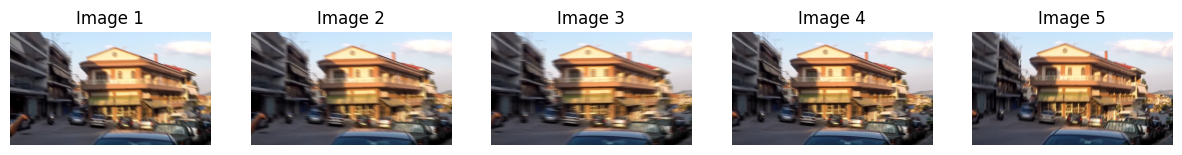

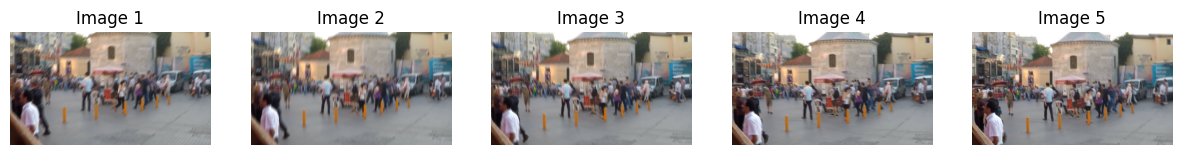

In [3]:
#show a few train image pairs
import matplotlib.pyplot as plt
import cv2
def show_image_pairs(image_paths, num_pairs=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_pairs):
        if i >= len(image_paths):
            break
        img = cv2.imread(image_paths[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_pairs, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image {i + 1}")
    plt.show()
show_image_pairs(train_image_paths, num_pairs=5)
#show a few test image pairs
show_image_pairs(test_image_paths, num_pairs=5)


In [4]:
#loading blurred and sharp images


import torch
from torch.utils.data import Dataset
import os
from PIL import Image
import torchvision.transforms as transforms

class GoProDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        
        # Collect all blur and blur_gamma images with their corresponding sharp images
        for item in os.listdir(root_dir):
            item_path = os.path.join(root_dir, item)
            if os.path.isdir(item_path):
                blur_dir = os.path.join(item_path, 'blur')
                blur_gamma_dir = os.path.join(item_path, 'blur_gamma')
                sharp_dir = os.path.join(item_path, 'sharp')
                
                # Add blur images
                if os.path.exists(blur_dir) and os.path.exists(sharp_dir):
                    for img_name in os.listdir(blur_dir):
                        self.samples.append({
                            'blur': os.path.join(blur_dir, img_name),
                            'sharp': os.path.join(sharp_dir, img_name)
                        })
                
                # Add blur_gamma images
                if os.path.exists(blur_gamma_dir) and os.path.exists(sharp_dir):
                    for img_name in os.listdir(blur_gamma_dir):
                        self.samples.append({
                            'blur': os.path.join(blur_gamma_dir, img_name),
                            'sharp': os.path.join(sharp_dir, img_name)
                        })
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        blur_img = Image.open(sample['blur']).convert('RGB')
        sharp_img = Image.open(sample['sharp']).convert('RGB')
        
        if self.transform:
            blur_img = self.transform(blur_img)
            sharp_img = self.transform(sharp_img)
        
        return blur_img, sharp_img
    
    

In [5]:
#storing in variables

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                            std=[0.5, 0.5, 0.5])
])
train_dataset = GoProDataset(train_data_path, transform=transform)
test_dataset = GoProDataset(test_data_path, transform=transform)

print(f"len train_dataset: {len(train_dataset)} ")
print(f"len test_dataset: {len(test_dataset)} ")

len train_dataset: 4206 
len test_dataset: 2222 


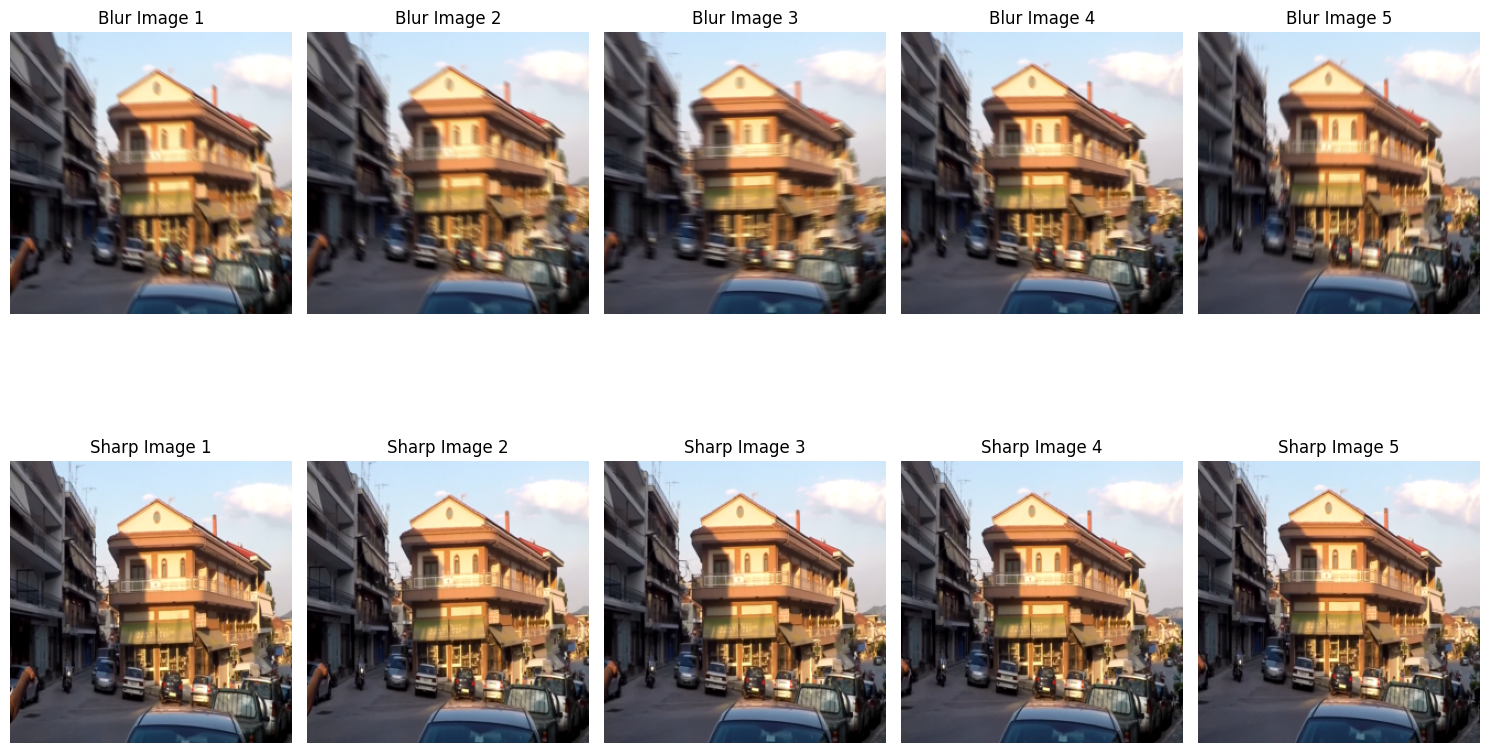

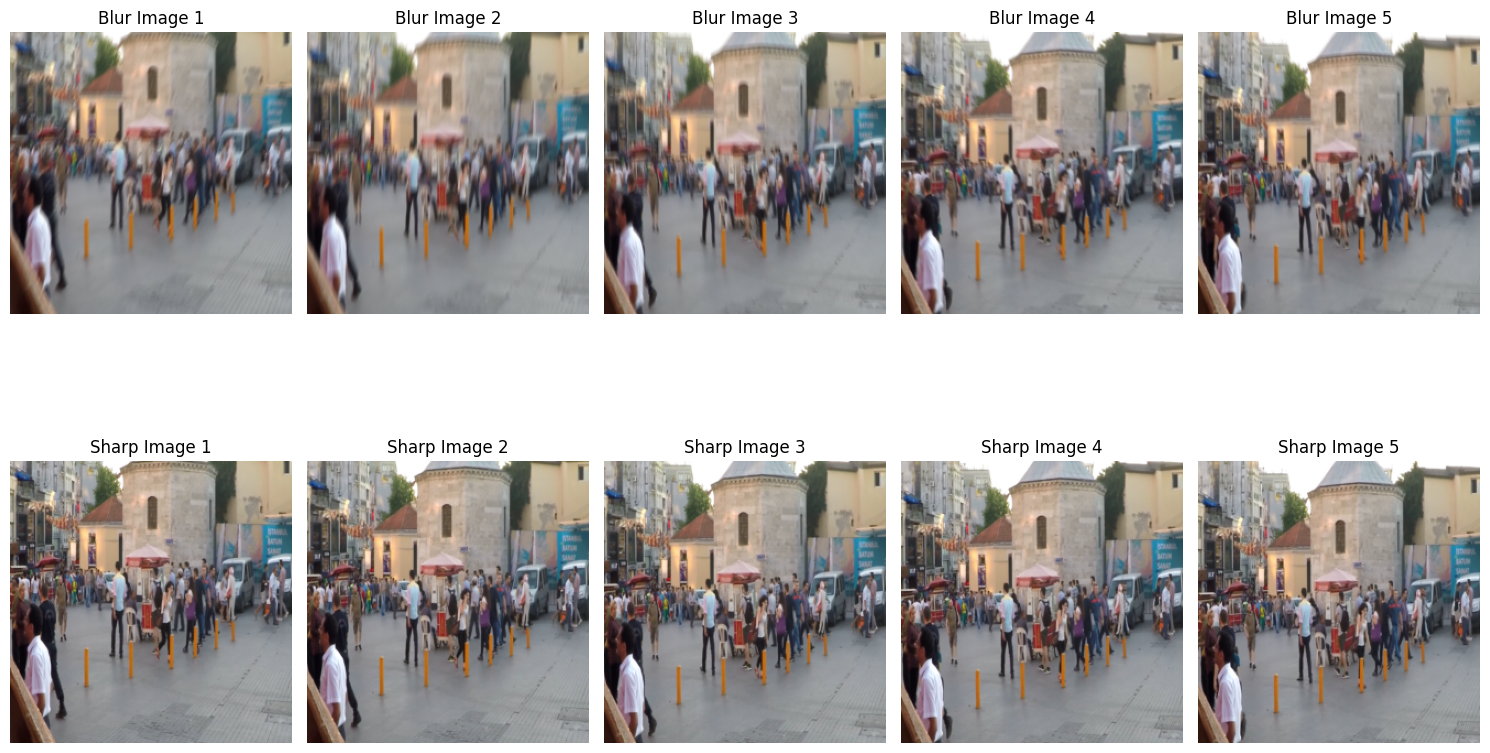

In [6]:
#plot a few train and test pairs
def plot_image_pairs(dataset, num_pairs=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_pairs):
        if i >= len(dataset):
            break
        blur_img, sharp_img = dataset[i]
        blur_img = blur_img.permute(1, 2, 0).numpy()
        sharp_img = sharp_img.permute(1, 2, 0).numpy()
        
        plt.subplot(2, num_pairs, i + 1)
        plt.imshow((blur_img + 1) / 2)  # Normalize back to [0, 1]
        plt.axis('off')
        plt.title(f"Blur Image {i + 1}")
        
        plt.subplot(2, num_pairs, i + 1 + num_pairs)
        plt.imshow((sharp_img + 1) / 2)  # Normalize back to [0, 1]
        plt.axis('off')
        plt.title(f"Sharp Image {i + 1}")
    
    plt.tight_layout()
    plt.show()
    
#call
plot_image_pairs(train_dataset, num_pairs=5)
plot_image_pairs(test_dataset, num_pairs=5)

## GAN Model Architecture

In this section, we will implement the GAN-based deblurring model consisting of:

### G}

### Discriminator Network
- **Convolutional neural network** to distinguish between real sharp images and generated deblurred images
- **PatchGAN architecture** for local texture discrimination
- **Leaky ReLU activations** and batch normalization layers

### Loss Functions
- **Adversarial Loss**: Standard GAN loss to train generator and discriminator
- **Content Loss**: L1 loss between generated and ground truth images for pixel-level accuracy
- **Perceptual Loss**: Feature-based loss using pre-trained VGG network for better visual quality

The model will be trained end-to-end to transform blurred input images into sharp, deblurred outputs while maintaining realistic image characteristics.

In [7]:
#imports for pytorch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import cv2
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

#set random seed for cuda and also numpy
torch.manual_seed(42)
np.random.seed(42)


# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Print the device being used
print(f"Using device: {device}")

Using device: cuda


In [8]:
"""#generator module using enerator Network
- **U-Net based architecture** with encoder-decoder structure
- **Skip connections** to preserve fine-grained details
- **Convolutional layers** with batch normalization and ReLU activations
- **Transpose convolutions** for upsampling in the decoder"""



'#generator module using enerator Network\n- **U-Net based architecture** with encoder-decoder structure\n- **Skip connections** to preserve fine-grained details\n- **Convolutional layers** with batch normalization and ReLU activations\n- **Transpose convolutions** for upsampling in the decoder'

In [12]:
#print cuda gpu information
import os
import torch
def print_cuda_info():
    if torch.cuda.is_available():
        print(f"CUDA Device Count: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            print(f"Device {i}: {torch.cuda.get_device_name(i)}")
            print(f"  Memory Allocated: {torch.cuda.memory_allocated(i) / (1024 ** 2):.2f} MB")
            print(f"  Memory Cached: {torch.cuda.memory_reserved(i) / (1024 ** 2):.2f} MB")
    else:
        print("CUDA is not available.")
        
print_cuda_info()

CUDA Device Count: 1
Device 0: NVIDIA GeForce RTX 4060
  Memory Allocated: 13992.83 MB
  Memory Cached: 14050.00 MB


In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data import DataLoader
# import torchvision
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# from collections import OrderedDict
# import time
# from dataclasses import dataclass
# from typing import Tuple, List
# import random

# @dataclass
# class ModelConfig:
#     """Configuration class for the deblurring GAN"""
#     # Generator parameters
#     gen_base_channels: int = 64
#     gen_depth: int = 8  # Number of encoder/decoder blocks
#     gen_skip_connections: bool = True
#     gen_attention: bool = True
    
#     # Discriminator parameters
#     disc_base_channels: int = 64
#     disc_depth: int = 6
#     disc_patch_size: int = 70  # PatchGAN receptive field
    
#     # Training parameters
#     batch_size: int = 8
#     learning_rate_g: float = 2e-4
#     learning_rate_d: float = 2e-4
#     beta1: float = 0.5
#     beta2: float = 0.999
#     weight_decay: float = 1e-4
    
#     # Loss weights
#     lambda_l1: float = 100.0
#     lambda_perceptual: float = 10.0
#     lambda_adversarial: float = 1.0
    
#     # Training schedule
#     num_epochs: int = 200
#     warmup_epochs: int = 10
#     scheduler_patience: int = 15
#     scheduler_factor: float = 0.5
#     early_stopping_patience: int = 30
    
#     # Monitoring
#     save_interval: int = 5
#     num_sample_images: int = 15
    
#     def get_total_params_estimate(self) -> int:
#         """Estimate total parameters for both networks"""
#         # Rough calculation based on architecture
#         gen_params = self.gen_base_channels * (2 ** self.gen_depth) * 1000
#         disc_params = self.disc_base_channels * (2 ** self.disc_depth) * 500
#         return gen_params + disc_params

# class AttentionBlock(nn.Module):
#     """Self-attention mechanism for generator"""
#     def __init__(self, channels: int):
#         super().__init__()
#         self.channels = channels
#         self.query = nn.Conv2d(channels, channels // 8, 1)
#         self.key = nn.Conv2d(channels, channels // 8, 1)
#         self.value = nn.Conv2d(channels, channels, 1)
#         self.gamma = nn.Parameter(torch.zeros(1))
        
#     def forward(self, x):
#         batch_size, channels, height, width = x.size()
        
#         # Generate query, key, value
#         q = self.query(x).view(batch_size, -1, height * width).permute(0, 2, 1)
#         k = self.key(x).view(batch_size, -1, height * width)
#         v = self.value(x).view(batch_size, -1, height * width)
        
#         # Compute attention
#         attention = torch.bmm(q, k)
#         attention = F.softmax(attention, dim=-1)
        
#         # Apply attention to values
#         out = torch.bmm(v, attention.permute(0, 2, 1))
#         out = out.view(batch_size, channels, height, width)
        
#         return self.gamma * out + x

# class ResidualBlock(nn.Module):
#     """Residual block with batch normalization"""
#     def __init__(self, channels: int):
#         super().__init__()
#         self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
#         self.bn1 = nn.BatchNorm2d(channels)
#         self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
#         self.bn2 = nn.BatchNorm2d(channels)
        
#     def forward(self, x):
#         residual = x
#         out = F.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         return F.relu(out + residual)

# class Generator(nn.Module):
#     """U-Net based generator with attention and residual blocks"""
#     def __init__(self, config: ModelConfig):
#         super().__init__()
#         self.config = config
#         base_ch = config.gen_base_channels
#         depth = config.gen_depth
        
#         # Encoder
#         self.encoder_blocks = nn.ModuleList()
#         in_ch = 3
        
#         for i in range(depth):
#             out_ch = base_ch * (2 ** min(i, 4))  # Cap at 1024 channels
            
#             if i == 0:
#                 # First block without downsampling
#                 block = nn.Sequential(
#                     nn.Conv2d(in_ch, out_ch, 7, padding=3),
#                     nn.BatchNorm2d(out_ch),
#                     nn.ReLU(inplace=True)
#                 )
#             else:
#                 block = nn.Sequential(
#                     nn.Conv2d(in_ch, out_ch, 4, stride=2, padding=1),
#                     nn.BatchNorm2d(out_ch),
#                     nn.ReLU(inplace=True),
#                     ResidualBlock(out_ch),
#                     ResidualBlock(out_ch)
#                 )
            
#             self.encoder_blocks.append(block)
#             in_ch = out_ch
        
#         # Bottleneck with attention
#         bottleneck_ch = base_ch * (2 ** min(depth-1, 4))
#         self.bottleneck = nn.Sequential(
#             ResidualBlock(bottleneck_ch),
#             AttentionBlock(bottleneck_ch) if config.gen_attention else nn.Identity(),
#             ResidualBlock(bottleneck_ch),
#             ResidualBlock(bottleneck_ch)
#         )
        
#         # Decoder
#         self.decoder_blocks = nn.ModuleList()
        
#         for i in range(depth):
#             level = depth - 1 - i
#             in_ch = base_ch * (2 ** min(level, 4))
#             out_ch = base_ch * (2 ** min(level-1, 4)) if level > 0 else base_ch
            
#             # Skip connection channels
#             skip_ch = in_ch if config.gen_skip_connections and level > 0 else 0
            
#             if i == depth - 1:
#                 # Last block - output RGB
#                 block = nn.Sequential(
#                     nn.ConvTranspose2d(in_ch + skip_ch, 64, 4, stride=2, padding=1),
#                     nn.BatchNorm2d(64),
#                     nn.ReLU(inplace=True),
#                     nn.Conv2d(64, 3, 7, padding=3),
#                     nn.Tanh()
#                 )
#             else:
#                 block = nn.Sequential(
#                     nn.ConvTranspose2d(in_ch + skip_ch, out_ch, 4, stride=2, padding=1),
#                     nn.BatchNorm2d(out_ch),
#                     nn.ReLU(inplace=True),
#                     ResidualBlock(out_ch)
#                 )
            
#             self.decoder_blocks.append(block)
    
#     def forward(self, x):
#         # Store skip connections
#         skip_connections = []
        
#         # Encoder forward pass
#         for i, block in enumerate(self.encoder_blocks):
#             x = block(x)
#             if i < len(self.encoder_blocks) - 1:  # Don't store last encoder output
#                 skip_connections.append(x)
        
#         # Bottleneck
#         x = self.bottleneck(x)
        
#         # Decoder forward pass
#         for i, block in enumerate(self.decoder_blocks):
#             # Add skip connection if available
#             if (self.config.gen_skip_connections and 
#                 i < len(skip_connections) and 
#                 i < len(self.decoder_blocks) - 1):
#                 skip_idx = len(skip_connections) - 1 - i
#                 skip = skip_connections[skip_idx]
#                 # Ensure spatial dimensions match
#                 if skip.shape[2:] != x.shape[2:]:
#                     skip = F.interpolate(skip, size=x.shape[2:], mode='bilinear', align_corners=False)
#                 x = torch.cat([x, skip], dim=1)
            
#             x = block(x)
        
#         return x

# class Discriminator(nn.Module):
#     """PatchGAN discriminator with spectral normalization"""
#     def __init__(self, config: ModelConfig):
#         super().__init__()
#         base_ch = config.disc_base_channels
#         depth = config.disc_depth
        
#         layers = []
#         in_ch = 6  # Concatenated blur and sharp/generated images
        
#         for i in range(depth):
#             out_ch = base_ch * (2 ** min(i, 4))  # Cap at 1024 channels
#             stride = 2 if i > 0 else 1
            
#             layers.append(nn.Conv2d(in_ch, out_ch, 4, stride=stride, padding=1))
            
#             if i > 0:  # No batch norm in first layer
#                 layers.append(nn.BatchNorm2d(out_ch))
            
#             layers.append(nn.LeakyReLU(0.2, inplace=True))
#             in_ch = out_ch
        
#         # Final classification layer
#         layers.append(nn.Conv2d(in_ch, 1, 4, padding=1))
        
#         self.model = nn.Sequential(*layers)
        
#         # Apply spectral normalization to conv layers
#         for module in self.modules():
#             if isinstance(module, nn.Conv2d):
#                 nn.utils.spectral_norm(module)
    
#     def forward(self, blur_img, sharp_img):
#         x = torch.cat([blur_img, sharp_img], dim=1)
#         return self.model(x)

# class PerceptualLoss(nn.Module):
#     """VGG-based perceptual loss"""
#     def __init__(self):
#         super().__init__()
#         vgg = torchvision.models.vgg19(weights='VGG19_Weights.DEFAULT').features
#         self.feature_extractor = nn.Sequential(*list(vgg.children())[:35]).eval()
        
#         # Freeze parameters
#         for param in self.feature_extractor.parameters():
#             param.requires_grad = False
    
#     def forward(self, generated, target):
#         # Normalize for VGG
#         generated_norm = (generated + 1) * 0.5  # [-1, 1] -> [0, 1]
#         target_norm = (target + 1) * 0.5
        
#         generated_features = self.feature_extractor(generated_norm)
#         target_features = self.feature_extractor(target_norm)
        
#         return F.mse_loss(generated_features, target_features)

# class EarlyStopping:
#     """Early stopping utility"""
#     def __init__(self, patience: int = 30, min_delta: float = 0.001):
#         self.patience = patience
#         self.min_delta = min_delta
#         self.counter = 0
#         self.best_loss = float('inf')
        
#     def __call__(self, val_loss: float) -> bool:
#         if val_loss < self.best_loss - self.min_delta:
#             self.best_loss = val_loss
#             self.counter = 0
#         else:
#             self.counter += 1
            
#         return self.counter >= self.patience

# class DeblurGAN:
#     """Main training class for the deblurring GAN"""
#     def __init__(self, config: ModelConfig):
#         self.config = config
#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
#         # Initialize models
#         self.generator = Generator(config).to(self.device)
#         self.discriminator = Discriminator(config).to(self.device)
        
#         # Print model parameters
#         gen_params = sum(p.numel() for p in self.generator.parameters())
#         disc_params = sum(p.numel() for p in self.discriminator.parameters())
#         total_params = gen_params + disc_params
        
#         print(f"Generator parameters: {gen_params:,}")
#         print(f"Discriminator parameters: {disc_params:,}")
#         print(f"Total parameters: {total_params:,}")
        
#         # Loss functions
#         self.adversarial_loss = nn.BCEWithLogitsLoss()
#         self.l1_loss = nn.L1Loss()
#         self.perceptual_loss = PerceptualLoss().to(self.device)
        
#         # Optimizers
#         self.optimizer_g = optim.Adam(
#             self.generator.parameters(),
#             lr=config.learning_rate_g,
#             betas=(config.beta1, config.beta2),
#             weight_decay=config.weight_decay
#         )
#         self.optimizer_d = optim.Adam(
#             self.discriminator.parameters(),
#             lr=config.learning_rate_d,
#             betas=(config.beta1, config.beta2),
#             weight_decay=config.weight_decay
#         )
        
#         # Schedulers
#         self.scheduler_g = optim.lr_scheduler.ReduceLROnPlateau(
#             self.optimizer_g, patience=config.scheduler_patience, 
#             factor=config.scheduler_factor, verbose=True
#         )
#         self.scheduler_d = optim.lr_scheduler.ReduceLROnPlateau(
#             self.optimizer_d, patience=config.scheduler_patience,
#             factor=config.scheduler_factor, verbose=True
#         )
        
#         # Early stopping
#         self.early_stopping = EarlyStopping(patience=config.early_stopping_patience)
        
#         # Training history
#         self.train_history = {
#             'g_loss': [], 'd_loss': [], 'val_loss': [],
#             'g_adv_loss': [], 'g_l1_loss': [], 'g_perceptual_loss': []
#         }
        
#         # Sample images for monitoring
#         self.sample_indices = None
        
#         # Create output directories
#         os.makedirs('checkpoints', exist_ok=True)
#         os.makedirs('sample_outputs', exist_ok=True)
    
#     def train_step(self, blur_imgs, sharp_imgs):
#         """Single training step"""
#         batch_size = blur_imgs.size(0)
        
#         # Real and fake labels
#         real_labels = torch.ones(batch_size, 1, 16, 16).to(self.device)  # Adjust size based on disc output
#         fake_labels = torch.zeros(batch_size, 1, 16, 16).to(self.device)
        
#         # ---------------------
#         # Train Discriminator
#         # ---------------------
#         self.optimizer_d.zero_grad()
        
#         # Real images
#         real_pred = self.discriminator(blur_imgs, sharp_imgs)
#         d_real_loss = self.adversarial_loss(real_pred, real_labels[:, :, :real_pred.size(2), :real_pred.size(3)])
        
#         # Fake images
#         with torch.no_grad():
#             fake_sharp = self.generator(blur_imgs)
#         fake_pred = self.discriminator(blur_imgs, fake_sharp.detach())
#         d_fake_loss = self.adversarial_loss(fake_pred, fake_labels[:, :, :fake_pred.size(2), :fake_pred.size(3)])
        
#         d_loss = (d_real_loss + d_fake_loss) * 0.5
#         d_loss.backward()
#         self.optimizer_d.step()
        
#         # -----------------
#         # Train Generator
#         # -----------------
#         self.optimizer_g.zero_grad()
        
#         # Generate images
#         generated_sharp = self.generator(blur_imgs)
        
#         # Adversarial loss
#         gen_pred = self.discriminator(blur_imgs, generated_sharp)
#         g_adv_loss = self.adversarial_loss(gen_pred, real_labels[:, :, :gen_pred.size(2), :gen_pred.size(3)])
        
#         # L1 loss
#         g_l1_loss = self.l1_loss(generated_sharp, sharp_imgs)
        
#         # Perceptual loss
#         g_perceptual_loss = self.perceptual_loss(generated_sharp, sharp_imgs)
        
#         # Combined generator loss
#         g_loss = (self.config.lambda_adversarial * g_adv_loss + 
#                  self.config.lambda_l1 * g_l1_loss + 
#                  self.config.lambda_perceptual * g_perceptual_loss)
        
#         g_loss.backward()
#         self.optimizer_g.step()
        
#         return {
#             'g_loss': g_loss.item(),
#             'd_loss': d_loss.item(),
#             'g_adv_loss': g_adv_loss.item(),
#             'g_l1_loss': g_l1_loss.item(),
#             'g_perceptual_loss': g_perceptual_loss.item()
#         }
    
#     def validate(self, val_loader):
#         """Validation step"""
#         self.generator.eval()
#         self.discriminator.eval()
        
#         total_val_loss = 0
#         num_batches = 0
        
#         with torch.no_grad():
#             for blur_imgs, sharp_imgs in val_loader:
#                 blur_imgs = blur_imgs.to(self.device)
#                 sharp_imgs = sharp_imgs.to(self.device)
                
#                 generated_sharp = self.generator(blur_imgs)
#                 val_loss = self.l1_loss(generated_sharp, sharp_imgs)
#                 total_val_loss += val_loss.item()
#                 num_batches += 1
        
#         avg_val_loss = total_val_loss / num_batches
#         return avg_val_loss
    
#     def save_sample_images(self, val_loader, epoch):
#         """Save sample images for monitoring progress"""
#         self.generator.eval()
        
#         # Get sample data
#         if self.sample_indices is None:
#             # Randomly select indices for consistent monitoring
#             total_samples = len(val_loader.dataset)
#             self.sample_indices = random.sample(range(total_samples), 
#                                               min(self.config.num_sample_images, total_samples))
        
#         sample_data = [val_loader.dataset[i] for i in self.sample_indices]
#         blur_imgs = torch.stack([item[0] for item in sample_data]).to(self.device)
#         sharp_imgs = torch.stack([item[1] for item in sample_data]).to(self.device)
        
#         with torch.no_grad():
#             generated_imgs = self.generator(blur_imgs)
        
#         # Create comparison grid
#         fig, axes = plt.subplots(len(sample_data), 3, figsize=(15, 5 * len(sample_data)))
#         if len(sample_data) == 1:
#             axes = axes.reshape(1, -1)
        
#         for i in range(len(sample_data)):
#             # Denormalize images
#             blur_img = (blur_imgs[i].cpu().permute(1, 2, 0) + 1) / 2
#             sharp_img = (sharp_imgs[i].cpu().permute(1, 2, 0) + 1) / 2
#             gen_img = (generated_imgs[i].cpu().permute(1, 2, 0) + 1) / 2
            
#             axes[i, 0].imshow(torch.clamp(blur_img, 0, 1))
#             axes[i, 0].set_title('Blurred Input')
#             axes[i, 0].axis('off')
            
#             axes[i, 1].imshow(torch.clamp(gen_img, 0, 1))
#             axes[i, 1].set_title('Generated')
#             axes[i, 1].axis('off')
            
#             axes[i, 2].imshow(torch.clamp(sharp_img, 0, 1))
#             axes[i, 2].set_title('Ground Truth')
#             axes[i, 2].axis('off')
        
#         plt.tight_layout()
#         plt.savefig(f'sample_outputs/epoch_{epoch:03d}.png', dpi=150, bbox_inches='tight')
#         plt.close()
        
#         self.generator.train()
    
#     def train(self, train_loader, val_loader):
#         """Main training loop"""
#         print(f"Starting training on {self.device}")
#         print(f"Training batches: {len(train_loader)}")
#         print(f"Validation batches: {len(val_loader)}")
        
#         best_val_loss = float('inf')
        
#         for epoch in range(self.config.num_epochs):
#             # Training phase
#             self.generator.train()
#             self.discriminator.train()
            
#             epoch_losses = {
#                 'g_loss': 0, 'd_loss': 0, 'g_adv_loss': 0,
#                 'g_l1_loss': 0, 'g_perceptual_loss': 0
#             }
            
#             start_time = time.time()
            
#             for batch_idx, (blur_imgs, sharp_imgs) in enumerate(train_loader):
#                 blur_imgs = blur_imgs.to(self.device)
#                 sharp_imgs = sharp_imgs.to(self.device)
                
#                 # Training step
#                 losses = self.train_step(blur_imgs, sharp_imgs)
                
#                 # Accumulate losses
#                 for key, value in losses.items():
#                     epoch_losses[key] += value
                
#                 # Print progress
#                 if batch_idx % 50 == 0:
#                     print(f"Epoch {epoch+1}/{self.config.num_epochs}, "
#                           f"Batch {batch_idx}/{len(train_loader)}, "
#                           f"G_Loss: {losses['g_loss']:.4f}, "
#                           f"D_Loss: {losses['d_loss']:.4f}")
            
#             # Average losses
#             for key in epoch_losses:
#                 epoch_losses[key] /= len(train_loader)
            
#             # Validation
#             val_loss = self.validate(val_loader)
            
#             # Update schedulers
#             self.scheduler_g.step(val_loss)
#             self.scheduler_d.step(val_loss)
            
#             # Save training history
#             self.train_history['g_loss'].append(epoch_losses['g_loss'])
#             self.train_history['d_loss'].append(epoch_losses['d_loss'])
#             self.train_history['val_loss'].append(val_loss)
#             self.train_history['g_adv_loss'].append(epoch_losses['g_adv_loss'])
#             self.train_history['g_l1_loss'].append(epoch_losses['g_l1_loss'])
#             self.train_history['g_perceptual_loss'].append(epoch_losses['g_perceptual_loss'])
            
#             epoch_time = time.time() - start_time
            
#             print(f"Epoch {epoch+1}/{self.config.num_epochs} completed in {epoch_time:.2f}s")
#             print(f"G_Loss: {epoch_losses['g_loss']:.4f}, D_Loss: {epoch_losses['d_loss']:.4f}, "
#                   f"Val_Loss: {val_loss:.4f}")
            
#             # Save sample images every 5 epochs
#             if (epoch + 1) % self.config.save_interval == 0:
#                 self.save_sample_images(val_loader, epoch + 1)
#                 print(f"Sample images saved for epoch {epoch + 1}")
            
#             # Save best model
#             if val_loss < best_val_loss:
#                 best_val_loss = val_loss
#                 torch.save({
#                     'epoch': epoch,
#                     'generator_state_dict': self.generator.state_dict(),
#                     'discriminator_state_dict': self.discriminator.state_dict(),
#                     'optimizer_g_state_dict': self.optimizer_g.state_dict(),
#                     'optimizer_d_state_dict': self.optimizer_d.state_dict(),
#                     'val_loss': val_loss,
#                     'config': self.config
#                 }, 'checkpoints/best_model.pth')
#                 print(f"Best model saved with validation loss: {val_loss:.4f}")
            
#             # Save periodic checkpoint
#             if (epoch + 1) % 10 == 0:
#                 torch.save({
#                     'epoch': epoch,
#                     'generator_state_dict': self.generator.state_dict(),
#                     'discriminator_state_dict': self.discriminator.state_dict(),
#                     'optimizer_g_state_dict': self.optimizer_g.state_dict(),
#                     'optimizer_d_state_dict': self.optimizer_d.state_dict(),
#                     'val_loss': val_loss,
#                     'config': self.config,
#                     'train_history': self.train_history
#                 }, f'checkpoints/checkpoint_epoch_{epoch+1}.pth')
            
#             # Early stopping
#             if self.early_stopping(val_loss):
#                 print(f"Early stopping triggered at epoch {epoch+1}")
#                 break
        
#         print("Training completed!")
        
#         # Plot training history
#         self.plot_training_history()
    
#     def plot_training_history(self):
#         """Plot training history"""
#         fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
#         # Generator and Discriminator loss
#         axes[0, 0].plot(self.train_history['g_loss'], label='Generator Loss')
#         axes[0, 0].plot(self.train_history['d_loss'], label='Discriminator Loss')
#         axes[0, 0].set_title('Generator vs Discriminator Loss')
#         axes[0, 0].set_xlabel('Epoch')
#         axes[0, 0].set_ylabel('Loss')
#         axes[0, 0].legend()
#         axes[0, 0].grid(True)
        
#         # Validation loss
#         axes[0, 1].plot(self.train_history['val_loss'], label='Validation Loss', color='red')
#         axes[0, 1].set_title('Validation Loss')
#         axes[0, 1].set_xlabel('Epoch')
#         axes[0, 1].set_ylabel('Loss')
#         axes[0, 1].legend()
#         axes[0, 1].grid(True)
        
#         # Generator loss components
#         axes[1, 0].plot(self.train_history['g_adv_loss'], label='Adversarial Loss')
#         axes[1, 0].plot(self.train_history['g_l1_loss'], label='L1 Loss')
#         axes[1, 0].plot(self.train_history['g_perceptual_loss'], label='Perceptual Loss')
#         axes[1, 0].set_title('Generator Loss Components')
#         axes[1, 0].set_xlabel('Epoch')
#         axes[1, 0].set_ylabel('Loss')
#         axes[1, 0].legend()
#         axes[1, 0].grid(True)
        
#         # Learning rates
#         axes[1, 1].plot([opt_state['lr'] for opt_state in self.optimizer_g.state_dict()['param_groups']], 
#                         label='Generator LR')
#         axes[1, 1].plot([opt_state['lr'] for opt_state in self.optimizer_d.state_dict()['param_groups']], 
#                         label='Discriminator LR')
#         axes[1, 1].set_title('Learning Rates')
#         axes[1, 1].set_xlabel('Epoch')
#         axes[1, 1].set_ylabel('Learning Rate')
#         axes[1, 1].legend()
#         axes[1, 1].grid(True)
        
#         plt.tight_layout()
#         plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
#         plt.show()

# # Initialize configuration and model
# config = ModelConfig(
#     gen_base_channels=64,
#     gen_depth=8,
#     disc_base_channels=64,
#     disc_depth=6,
#     batch_size=4,  # Adjust based on GPU memory
#     learning_rate_g=1e-4,
#     learning_rate_d=1e-4,
#     num_epochs=100,
#     save_interval=5,
#     num_sample_images=15
# )

# print(f"Estimated total parameters: {config.get_total_params_estimate():,}")

# # Initialize the GAN
# deblur_gan = DeblurGAN(config)

Estimated total parameters: 18,432,000
Generator parameters: 468,838,980
Discriminator parameters: 27,949,761
Total parameters: 496,788,741


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\Gabriel/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:40<00:00, 14.3MB/s] 
c:\Users\Gabriel\anaconda3\envs\cudaenv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### not using the class-based approach


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import random

# Configuration parameters - directly accessible
CONFIG = {
    # Generator parameters
    'gen_base_channels': 128,  # Increased for more parameters
    'gen_depth': 9,           # Deeper network
    'gen_skip_connections': True,
    'gen_attention': True,
    
    # Discriminator parameters
    'disc_base_channels': 128,  # Increased for more parameters
    'disc_depth': 7,           # Deeper discriminator
    
    # Training parameters
    'batch_size': 4,
    'learning_rate_g': 1e-4,
    'learning_rate_d': 1e-4,
    'beta1': 0.5,
    'beta2': 0.999,
    'weight_decay': 1e-4,
    
    # Loss weights
    'lambda_l1': 100.0,
    'lambda_perceptual': 10.0,
    'lambda_adversarial': 1.0,
    
    # Training schedule
    'num_epochs': 100,
    'scheduler_patience': 15,
    'scheduler_factor': 0.5,
    'early_stopping_patience': 30,
    
    # Monitoring
    'save_interval': 5,
    'num_sample_images': 15
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model components
class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.query = nn.Conv2d(channels, channels // 8, 1)
        self.key = nn.Conv2d(channels, channels // 8, 1)
        self.value = nn.Conv2d(channels, channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))
        
    def forward(self, x):
        batch_size, channels, height, width = x.size()
        
        q = self.query(x).view(batch_size, -1, height * width).permute(0, 2, 1)
        k = self.key(x).view(batch_size, -1, height * width)
        v = self.value(x).view(batch_size, -1, height * width)
        
        attention = torch.bmm(q, k)
        attention = F.softmax(attention, dim=-1)
        
        out = torch.bmm(v, attention.permute(0, 2, 1))
        out = out.view(batch_size, channels, height, width)
        
        return self.gamma * out + x

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        
    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return F.relu(out + residual)

class DenseBlock(nn.Module):
    """Dense block for more parameters"""
    def __init__(self, channels, growth_rate=32):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, growth_rate, 1)
        self.conv2 = nn.Conv2d(growth_rate, growth_rate, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(growth_rate)
        self.bn2 = nn.BatchNorm2d(growth_rate)
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return torch.cat([x, out], dim=1)

class Generator(nn.Module):
    def __init__(self, config):
        super().__init__()
        base_ch = config['gen_base_channels']
        depth = config['gen_depth']
        
        # Encoder with more layers and parameters
        self.encoder_blocks = nn.ModuleList()
        in_ch = 3
        
        for i in range(depth):
            out_ch = base_ch * (2 ** min(i, 4))  # Cap at 2048 channels
            
            if i == 0:
                block = nn.Sequential(
                    nn.Conv2d(in_ch, out_ch, 7, padding=3),
                    nn.BatchNorm2d(out_ch),
                    nn.ReLU(inplace=True),
                    DenseBlock(out_ch),
                    DenseBlock(out_ch + 32)
                )
                out_ch += 64  # Account for dense blocks
            else:
                block = nn.Sequential(
                    nn.Conv2d(in_ch, out_ch, 4, stride=2, padding=1),
                    nn.BatchNorm2d(out_ch),
                    nn.ReLU(inplace=True),
                    ResidualBlock(out_ch),
                    ResidualBlock(out_ch),
                    DenseBlock(out_ch),
                    ResidualBlock(out_ch + 32)
                )
                out_ch += 32  # Account for dense block
            
            self.encoder_blocks.append(block)
            in_ch = out_ch
        
        # Bottleneck with multiple attention blocks
        self.bottleneck = nn.Sequential(
            ResidualBlock(in_ch),
            AttentionBlock(in_ch) if config['gen_attention'] else nn.Identity(),
            ResidualBlock(in_ch),
            ResidualBlock(in_ch),
            AttentionBlock(in_ch) if config['gen_attention'] else nn.Identity(),
            ResidualBlock(in_ch)
        )
        
        # Decoder with skip connections
        self.decoder_blocks = nn.ModuleList()
        self.skip_channels = []
        
        # Calculate skip connection channels
        temp_ch = 3
        for i in range(depth):
            if i == 0:
                temp_ch = base_ch + 64
            else:
                temp_ch = base_ch * (2 ** min(i, 4)) + 32
            if i < depth - 1:
                self.skip_channels.append(temp_ch)
        
        for i in range(depth):
            level = depth - 1 - i
            
            if level == 0:
                in_ch_dec = base_ch + 64
            else:
                in_ch_dec = base_ch * (2 ** min(level, 4)) + 32
            
            # Skip connection
            skip_ch = self.skip_channels[level - 1] if (config['gen_skip_connections'] and level > 0) else 0
            
            if i == depth - 1:
                # Final output layer
                out_ch_dec = 64
                block = nn.Sequential(
                    nn.ConvTranspose2d(in_ch_dec + skip_ch, out_ch_dec, 4, stride=2, padding=1),
                    nn.BatchNorm2d(out_ch_dec),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(out_ch_dec, 32, 3, padding=1),
                    nn.BatchNorm2d(32),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(32, 3, 7, padding=3),
                    nn.Tanh()
                )
            else:
                if level == 1:
                    out_ch_dec = base_ch + 64
                else:
                    out_ch_dec = base_ch * (2 ** min(level-1, 4)) + 32
                    
                block = nn.Sequential(
                    nn.ConvTranspose2d(in_ch_dec + skip_ch, out_ch_dec - 32, 4, stride=2, padding=1),
                    nn.BatchNorm2d(out_ch_dec - 32),
                    nn.ReLU(inplace=True),
                    ResidualBlock(out_ch_dec - 32),
                    DenseBlock(out_ch_dec - 32)
                )
            
            self.decoder_blocks.append(block)
    
    def forward(self, x):
        skip_connections = []
        
        # Encoder
        for i, block in enumerate(self.encoder_blocks):
            x = block(x)
            if i < len(self.encoder_blocks) - 1:
                skip_connections.append(x)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoder
        for i, block in enumerate(self.decoder_blocks):
            if (CONFIG['gen_skip_connections'] and 
                i < len(skip_connections) and 
                i < len(self.decoder_blocks) - 1):
                skip_idx = len(skip_connections) - 1 - i
                skip = skip_connections[skip_idx]
                if skip.shape[2:] != x.shape[2:]:
                    skip = F.interpolate(skip, size=x.shape[2:], mode='bilinear', align_corners=False)
                x = torch.cat([x, skip], dim=1)
            
            x = block(x)
        
        return x

class Discriminator(nn.Module):
    def __init__(self, config):
        super().__init__()
        base_ch = config['disc_base_channels']
        depth = config['disc_depth']
        
        layers = []
        in_ch = 6  # Blur + sharp/generated
        
        for i in range(depth):
            out_ch = base_ch * (2 ** min(i, 4))
            stride = 2 if i > 0 else 1
            
            layers.extend([
                nn.utils.spectral_norm(nn.Conv2d(in_ch, out_ch, 4, stride=stride, padding=1)),
                nn.BatchNorm2d(out_ch) if i > 0 else nn.Identity(),
                nn.LeakyReLU(0.2, inplace=True)
            ])
            
            # Add extra conv layers for more parameters
            if i > 0:
                layers.extend([
                    nn.utils.spectral_norm(nn.Conv2d(out_ch, out_ch, 3, padding=1)),
                    nn.BatchNorm2d(out_ch),
                    nn.LeakyReLU(0.2, inplace=True)
                ])
            
            in_ch = out_ch
        
        # Final layers
        layers.extend([
            nn.utils.spectral_norm(nn.Conv2d(in_ch, in_ch // 2, 3, padding=1)),
            nn.BatchNorm2d(in_ch // 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Conv2d(in_ch // 2, 1, 4, padding=1))
        ])
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, blur_img, sharp_img):
        x = torch.cat([blur_img, sharp_img], dim=1)
        return self.model(x)

class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = torchvision.models.vgg19(weights='VGG19_Weights.DEFAULT').features
        self.feature_extractor = nn.Sequential(*list(vgg.children())[:35]).eval()
        
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
    
    def forward(self, generated, target):
        generated_norm = (generated + 1) * 0.5
        target_norm = (target + 1) * 0.5
        
        generated_features = self.feature_extractor(generated_norm)
        target_features = self.feature_extractor(target_norm)
        
        return F.mse_loss(generated_features, target_features)

# Initialize models directly
generator = Generator(CONFIG).to(device)
discriminator = Discriminator(CONFIG).to(device)
perceptual_loss = PerceptualLoss().to(device)

# Print parameter counts
gen_params = sum(p.numel() for p in generator.parameters())
disc_params = sum(p.numel() for p in discriminator.parameters())
total_params = gen_params + disc_params

print(f"Generator parameters: {gen_params:,}")
print(f"Discriminator parameters: {disc_params:,}")
print(f"Total parameters: {total_params:,}")

# Loss functions
adversarial_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

# Optimizers
optimizer_g = optim.Adam(
    generator.parameters(),
    lr=CONFIG['learning_rate_g'],
    betas=(CONFIG['beta1'], CONFIG['beta2']),
    weight_decay=CONFIG['weight_decay']
)
optimizer_d = optim.Adam(
    discriminator.parameters(),
    lr=CONFIG['learning_rate_d'],
    betas=(CONFIG['beta1'], CONFIG['beta2']),
    weight_decay=CONFIG['weight_decay']
)

# Schedulers
scheduler_g = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_g, patience=CONFIG['scheduler_patience'], 
    factor=CONFIG['scheduler_factor'], verbose=True
)
scheduler_d = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_d, patience=CONFIG['scheduler_patience'],
    factor=CONFIG['scheduler_factor'], verbose=True
)

# Training history
train_history = {
    'g_loss': [], 'd_loss': [], 'val_loss': [],
    'g_adv_loss': [], 'g_l1_loss': [], 'g_perceptual_loss': []
}

# Create directories
os.makedirs('checkpoints', exist_ok=True)
os.makedirs('sample_outputs', exist_ok=True)

# Training functions
def train_step(blur_imgs, sharp_imgs):
    batch_size = blur_imgs.size(0)
    
    # Train Discriminator
    optimizer_d.zero_grad()
    
    # Real images
    real_pred = discriminator(blur_imgs, sharp_imgs)
    real_labels = torch.ones_like(real_pred).to(device)
    d_real_loss = adversarial_loss(real_pred, real_labels)
    
    # Fake images
    with torch.no_grad():
        fake_sharp = generator(blur_imgs)
    fake_pred = discriminator(blur_imgs, fake_sharp.detach())
    fake_labels = torch.zeros_like(fake_pred).to(device)
    d_fake_loss = adversarial_loss(fake_pred, fake_labels)
    
    d_loss = (d_real_loss + d_fake_loss) * 0.5
    d_loss.backward()
    optimizer_d.step()
    
    # Train Generator
    optimizer_g.zero_grad()
    
    generated_sharp = generator(blur_imgs)
    
    # Adversarial loss
    gen_pred = discriminator(blur_imgs, generated_sharp)
    real_labels = torch.ones_like(gen_pred).to(device)
    g_adv_loss = adversarial_loss(gen_pred, real_labels)
    
    # L1 loss
    g_l1_loss = l1_loss(generated_sharp, sharp_imgs)
    
    # Perceptual loss
    g_perceptual_loss = perceptual_loss(generated_sharp, sharp_imgs)
    
    # Combined generator loss
    g_loss = (CONFIG['lambda_adversarial'] * g_adv_loss + 
             CONFIG['lambda_l1'] * g_l1_loss + 
             CONFIG['lambda_perceptual'] * g_perceptual_loss)
    
    g_loss.backward()
    optimizer_g.step()
    
    return {
        'g_loss': g_loss.item(),
        'd_loss': d_loss.item(),
        'g_adv_loss': g_adv_loss.item(),
        'g_l1_loss': g_l1_loss.item(),
        'g_perceptual_loss': g_perceptual_loss.item()
    }

def validate(val_loader):
    generator.eval()
    discriminator.eval()
    
    total_val_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for blur_imgs, sharp_imgs in val_loader:
            blur_imgs = blur_imgs.to(device)
            sharp_imgs = sharp_imgs.to(device)
            
            generated_sharp = generator(blur_imgs)
            val_loss = l1_loss(generated_sharp, sharp_imgs)
            total_val_loss += val_loss.item()
            num_batches += 1
    
    return total_val_loss / num_batches

# Sample indices for consistent monitoring
sample_indices = None

def save_sample_images(val_loader, epoch):
    global sample_indices
    generator.eval()
    
    if sample_indices is None:
        total_samples = len(val_loader.dataset)
        sample_indices = random.sample(range(total_samples), 
                                     min(CONFIG['num_sample_images'], total_samples))
    
    sample_data = [val_loader.dataset[i] for i in sample_indices]
    blur_imgs = torch.stack([item[0] for item in sample_data]).to(device)
    sharp_imgs = torch.stack([item[1] for item in sample_data]).to(device)
    
    with torch.no_grad():
        generated_imgs = generator(blur_imgs)
    
    # Create comparison grid
    fig, axes = plt.subplots(len(sample_data), 3, figsize=(15, 5 * len(sample_data)))
    if len(sample_data) == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(len(sample_data)):
        blur_img = (blur_imgs[i].cpu().permute(1, 2, 0) + 1) / 2
        sharp_img = (sharp_imgs[i].cpu().permute(1, 2, 0) + 1) / 2
        gen_img = (generated_imgs[i].cpu().permute(1, 2, 0) + 1) / 2
        
        axes[i, 0].imshow(torch.clamp(blur_img, 0, 1))
        axes[i, 0].set_title('Blurred Input')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(torch.clamp(gen_img, 0, 1))
        axes[i, 1].set_title('Generated')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(torch.clamp(sharp_img, 0, 1))
        axes[i, 2].set_title('Ground Truth')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'sample_outputs/epoch_{epoch:03d}.png', dpi=150, bbox_inches='tight')
    plt.close()
    
    generator.train()

def plot_training_history():
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Generator and Discriminator loss
    axes[0, 0].plot(train_history['g_loss'], label='Generator Loss')
    axes[0, 0].plot(train_history['d_loss'], label='Discriminator Loss')
    axes[0, 0].set_title('Generator vs Discriminator Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Validation loss
    axes[0, 1].plot(train_history['val_loss'], label='Validation Loss', color='red')
    axes[0, 1].set_title('Validation Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Generator loss components
    axes[1, 0].plot(train_history['g_adv_loss'], label='Adversarial Loss')
    axes[1, 0].plot(train_history['g_l1_loss'], label='L1 Loss')
    axes[1, 0].plot(train_history['g_perceptual_loss'], label='Perceptual Loss')
    axes[1, 0].set_title('Generator Loss Components')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Learning rates
    axes[1, 1].plot(range(len(train_history['g_loss'])), 
                   [optimizer_g.param_groups[0]['lr']] * len(train_history['g_loss']), 
                   label='Generator LR')
    axes[1, 1].plot(range(len(train_history['d_loss'])), 
                   [optimizer_d.param_groups[0]['lr']] * len(train_history['d_loss']), 
                   label='Discriminator LR')
    axes[1, 1].set_title('Learning Rates')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
    plt.show()

print("Models initialized successfully!")
print("Ready to start training...")

Using device: cuda
Generator parameters: 2,805,531,381
Discriminator parameters: 323,368,577
Total parameters: 3,128,899,958
Models initialized successfully!
Ready to start training...
